# Imports

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
from operator import itemgetter
import seaborn as sns
import matplotlib.gridspec as gridspec

sns.set_context('notebook')
sns.set_style('white')

# Read in Databases

## Causal cohort

In [3]:
conn = sqlite3.connect('../../Data/Experiment_2/exp2_remote.db')
dat2 = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.completion=1', con=conn)
anim = dat2.loc[(dat2.anim_check == 1) &
              (dat2.tower_check == 1 ) & (dat2.agent_check==1)]
inanim = dat2[['inanim' in x for x in dat2.exp_cond]]
inanim = inanim.loc[(dat2.anim_check == 1) & (dat2.tower_check == 1 )]
dat2 = pd.concat([anim, inanim])
dat2 = pd.DataFrame(dat2.values[:,~dat2.columns.duplicated()], columns=dat2.columns[~dat2.columns.duplicated()])

dat2['cause_agent'] = dat2['cause_agent'].apply(literal_eval)
dat2['cause_patient'] = dat2['cause_patient'].apply(literal_eval)
dat2['num_moves_cause_agent'] = [len(x) for x in dat2.cause_agent]
dat2['agent'] = dat2.cause_agent.map(lambda x: x[-1])
dat2['num_moves_cause_patient'] = [len(x) for x in dat2.cause_patient]
dat2['patient'] = dat2.cause_patient.map(lambda x:x[-1])
#dat2['exp_cond'] = dat2.exp_cond.map(lambda x: x.split('_'))
#dat2[['animacy', 'norm_violation']] = dat2['exp_cond'].transform({'item1': itemgetter(0), 'item2': itemgetter(1)})
dat2.rename(columns={'exp_cond': 'condition'}, inplace=True)

df2 = pd.DataFrame(dat2.condition.str.split('_'))
dat2[['animacy', 'norm_violation']] = pd.DataFrame(df2.condition.tolist(), index=dat2.index)

xx = dat2.groupby('prolificID').count().id > 1 # some subjects are in the DB with duplicate rows
extrasubs = xx.loc[xx.values == True].index.tolist()
for subj in extrasubs:
    dat2.drop(dat2.loc[dat2.prolificID == subj].index[0], inplace=True)
dat2.reset_index(drop=True, inplace=True)
# randomly remove some subjects from the inanimate condition
dat2.drop(index=dat2.loc[(dat2.animacy == 'inanimate') & (dat2.norm_violation == 'moral')].sample(50).index.tolist(),
          inplace=True)
dat2.drop(index=dat2.loc[(dat2.animacy == 'inanimate') & (dat2.norm_violation == 'rational')].sample(50).index.tolist(),
          inplace=True)
dat2.loc[dat2.animacy == 'inanimate', 'condition'] = 'inanimate'

dat2.groupby('condition').subject_id.count()

condition
animate_moral       98
animate_rational    97
inanimate           97
Name: subject_id, dtype: int64

## Counterfactual Cohort

In [2]:

conn = sqlite3.connect('../../Data/Experiment_3/Bryan_exp3_remote.db')
dat3 = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.completion=1', con=conn)

# Only use indices where comprehension questions were answered correctly
anim = dat3.loc[(dat3.anim_check == 1) & (dat3.tower_check == 1 ) & (dat3.agent_check==1)]
inanim = dat3[['inanim' in x for x in dat3.exp_cond]].loc[(dat3.anim_check == 1) & (dat3.tower_check == 1 )] # animate condition had a third comprehension check
inanim['exp_cond'] = 'inanimate' # this should collapse the 'moral' and 'rational' conditions in the inanimate case, where they don't mean anything
dat3 = pd.concat([anim, inanim])
# remove duplicate columns that came from the SQL inner join
dat3 = pd.DataFrame(dat3.values[:,~dat3.columns.duplicated()], columns=dat3.columns[~dat3.columns.duplicated()])
# remove subjects who somehow ended up with multiple rows (from refreshing or some other unknown reason)
xx = dat3.groupby('prolificID').count().id > 1
extrasubs = xx.loc[xx.values == True].index.tolist()
for subj in extrasubs:
    b = dat3.loc[dat3.prolificID == subj].index == dat3.loc[dat3.prolificID == subj].index.max() # take only the final attempt at the task
    dat3.drop(dat3.loc[dat3.prolificID == subj].index[~b], inplace=True)

#  slider dat3a recorded as lists, to capture when pps might have changed their minds.
#  reformate from list to final value
for prompt in ["Q0", "Q1", "Q2","Q3"]:
    dat3[prompt] = dat3[prompt].apply(literal_eval)
    dat3['num_moves'+prompt] = [len(x) for x in dat3[prompt]]
    dat3['Q'+prompt] = dat3[prompt].map(lambda x: x[-1]) # last value in the list, aka pps final answer

del anim, inanim, xx, extrasubs, b, subj, prompt

# n's are not matching. Lowest is animate moral (98) drop random index so they match
dat3.drop(np.random.choice(dat3.loc[dat3.exp_cond == 'animate_rational'].index, size=3), inplace=True)
dat3.drop(np.random.choice(dat3.loc[dat3.exp_cond == 'inanimate'].index, size=1), inplace=True)
dat3.reset_index(drop=True, inplace=True)
dat3.rename(columns={'exp_cond': 'condition'}, inplace=True)

df3 = pd.DataFrame(dat3.condition.str.split('_'))
dat3[['animacy', 'norm_violation']] = pd.DataFrame(df3.condition.tolist(), index=dat3.index)
dat3.groupby('condition').subject_id.count()

condition
animate_moral       98
animate_rational    98
inanimate           98
Name: subject_id, dtype: int64

# Participant Demos

In [4]:
import os
from glob import glob
demos = pd.DataFrame()
for file in glob(os.path.join("../../Data/Experiment_2","*prolific_export_*.csv" )):
    demos = pd.concat([demos, pd.read_csv(file, index_col=None)])
len(demos.participant_id.unique())
demos = demos.loc[demos.participant_id.isin(dat2.prolificID.unique())]
len(demos.participant_id.unique())
len(demos.loc[demos.Sex == 'Female'].participant_id.unique())
#demos.loc[demos.age != 'DATA_EXPIRED'].age.mean()

99

# Causal Judgments

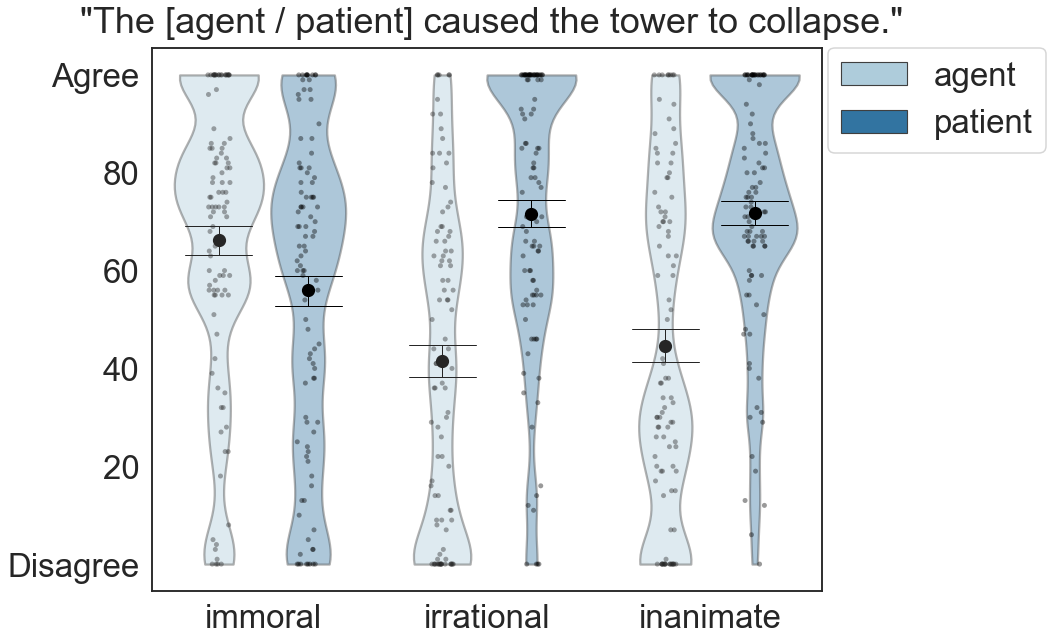

In [5]:
sns.set_context('talk', font_scale=2)

d2 = dat2.melt(id_vars=['prolificID', 'condition'], value_vars=['agent', 'patient'], var_name='Ball', value_name='Causal Rating')
fig, ax = plt.subplots(figsize=(15,10))

g = sns.violinplot(x='condition', y='Causal Rating', hue='Ball', data=d2, inner=None, cut=0, bw=.18, palette=sns.color_palette("Paired"), order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'])
[x.set_alpha(.4) for x in g.axes.collections]

g = sns.stripplot(x='condition', y='Causal Rating', hue='Ball', data=d2, alpha=.4, dodge=.4, color='k', order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'])

g = sns.pointplot(x='condition', y='Causal Rating', hue='Ball', data=d2, join=False, order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'], capsize=.3, errwidth=1, ci=68, scale=1, dodge=.4, color='k')
g.legend_.remove()
ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,ncol=1)
g.legend = False
#ax.text(-.09, 108, "n="+str(len(d2.loc[(d2.condition=='animate_moral') ])))
#ax.text(1, 108, "n="+str(len(d2.loc[(d2.condition=='animate_rational')  ])))
#ax.text(2, 108, "n="+str(len(d2.loc[(d2.condition=='inanimate') ])))
#ax.set_ylabel(' \"The [agent / patient] caused \n the tower to collapse.\"', rotation=90, labelpad=-30)
ax.set_title(' \"The [agent / patient] caused the tower to collapse.\"', rotation=0, pad=15)

ax.set_xlabel('')
ax.set_ylabel('')

ax.set_yticklabels(['0', 'Disagree', '20', '40', '60', '80', 'Agree']);
ax.set_xticklabels(['immoral', 'irrational', 'inanimate'])
fig.subplots_adjust(left=.15, right=.77)
fig.savefig('Figures/Exp2_cause.png')


# Counterfactual Judgements

In [3]:
d3 = dat3.melt(id_vars=['prolificID', 'condition'], value_vars=['Q0', 'Q1', 'Q2', 'Q3',], value_name='agreement', var_name='CF_question')
d3['agreement'] = d3.agreement.map(lambda x: x[-1])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


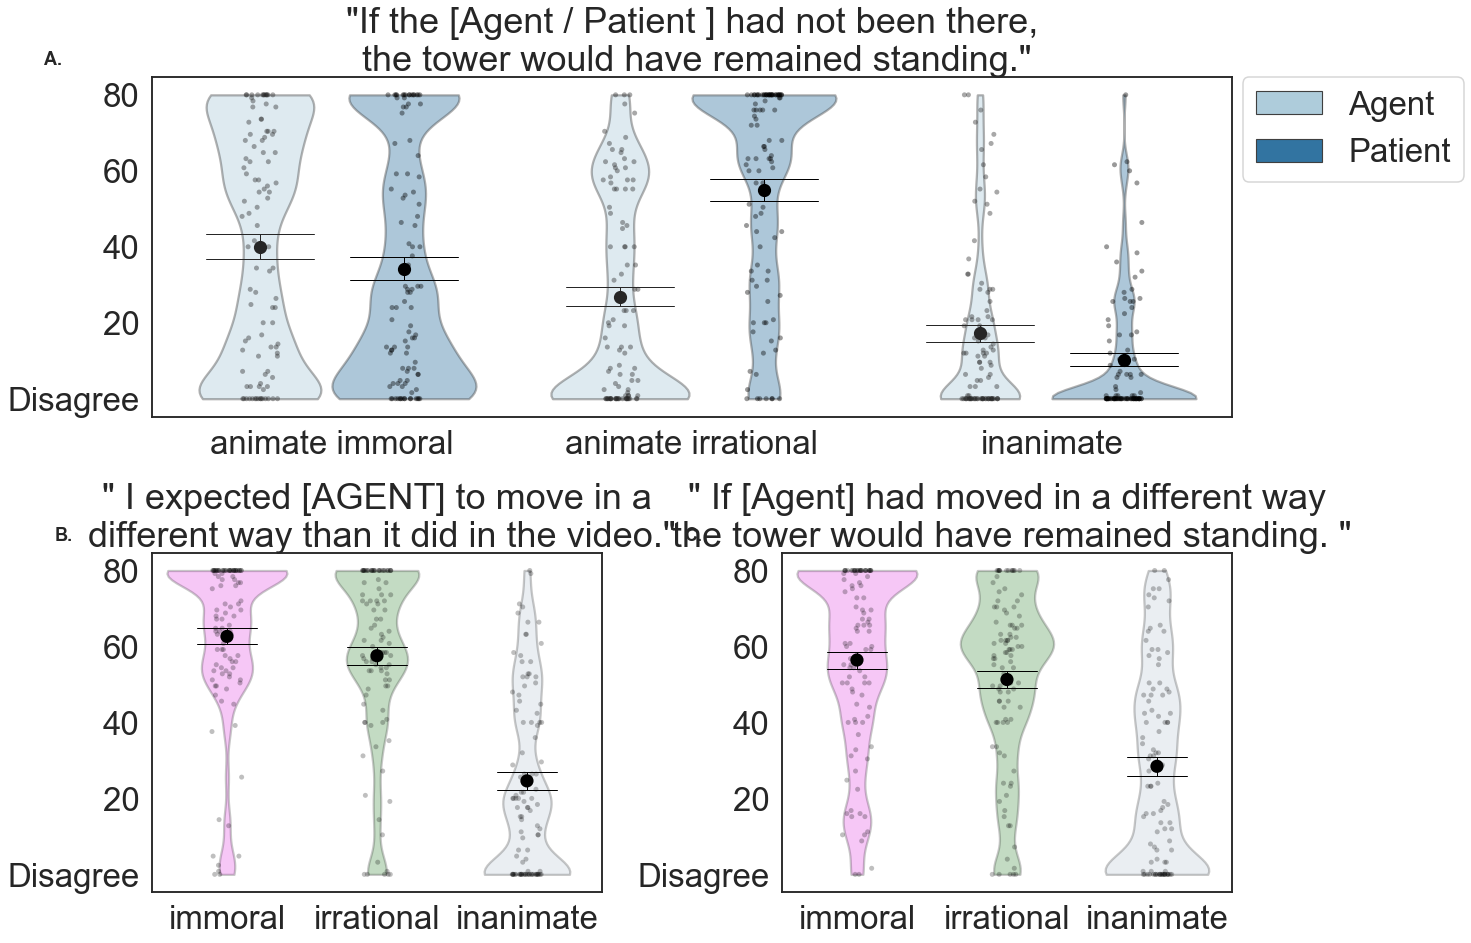

In [14]:

fig = plt.figure(tight_layout=True, figsize=(25, 15))
gs = gridspec.GridSpec(2, 2, hspace=.4, wspace=.4, left=.3)

a1 = fig.add_subplot(gs[1, 1])
d3_diff = d3.loc[d3.CF_question == 'Q3']
sns.violinplot(x='condition', y='agreement',  data=d3_diff, cut=0, bw=.18, order=['animate_moral', 'animate_rational', 'inanimate'], inner=None, ax=a1, palette=['#FF00FF', 'g', '#a8c0d2'])
[x.set_alpha(.25) for x in a1.collections]

sns.stripplot(x='condition', y='agreement',  data=d3_diff, alpha=.25,  color='k', order=['animate_moral', 'animate_rational', 'inanimate'],  ax=a1)
sns.pointplot(x='condition', y='agreement',  data=d3_diff,  color='k', order=['animate_moral', 'animate_rational', 'inanimate'], ax=a1, join=False, capsize=.4, errwidth=1, ci=68, scale=1)
a1.set_xlabel('')
a1.set_ylabel('')
a1.set_yticklabels(['0', 'Disagree', '20', '40', '60', '80', 'Agree']);
a1.set_xticklabels(['immoral', 'irrational', 'inanimate'])
a1.title.set_text('\" If [Agent] had moved in a different way\n the tower would have remained standing. \"')
a1.text(-1.15, 110, "C.",fontsize=18, fontweight='bold' );



a2 = fig.add_subplot(gs[1, 0])
d3_exp = d3.loc[d3.CF_question == 'Q2']
sns.violinplot(x='condition', y='agreement',  data=d3_exp, cut=0, bw=.18, order=['animate_moral', 'animate_rational', 'inanimate'], inner=None, ax=a2, palette=['#FF00FF', 'g', '#a8c0d2'])
[x.set_alpha(.25) for x in a2.collections]

sns.stripplot(x='condition', y='agreement',  data=d3_exp, alpha=.25,  color='k', order=['animate_moral', 'animate_rational', 'inanimate'],  ax=a2)
sns.pointplot(x='condition', y='agreement',  data=d3_exp,  color='k', order=['animate_moral', 'animate_rational', 'inanimate'], ax=a2, join=False, capsize=.4, errwidth=1, ci=68, scale=1)
a2.set_xlabel('')
a2.set_ylabel('')
a2.set_yticklabels(['0', 'Disagree', '20', '40', '60', '80', 'Agree']);
a2.set_xticklabels(['immoral', 'irrational', 'inanimate'])
a2.title.set_text('\" I expected [AGENT] to move in a\n different way than it did in the video.\"')
a2.text(-1.15, 110, "B.",fontsize=18, fontweight='bold' );


a3 = fig.add_subplot(gs[0, :])
d3_cfd = d3.loc[(d3.CF_question == 'Q0') | (d3.CF_question == 'Q1')]
d3_cfd.loc[d3_cfd.CF_question == "Q0", 'CF_question'] = "Agent"
d3_cfd.loc[d3_cfd.CF_question == "Q1", 'CF_question'] = "Patient"
sns.violinplot(x='condition', y='agreement',hue='CF_question', data=d3_cfd, cut=0, bw=.18, palette=sns.color_palette("Paired"), order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['Agent', 'Patient'], inner=None, ax=a3)
[x.set_alpha(.4) for x in a3.collections]
sns.stripplot(x='condition', y='agreement', hue='CF_question', data=d3_cfd, alpha=.4, dodge=.4, color='k', order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['Agent', 'Patient'], ax=a3)
sns.pointplot(x='condition', y='agreement', hue='CF_question', data=d3_cfd, dodge=.4, color='k', order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['Agent', 'Patient'], ax=a3, join=False, capsize=.3, errwidth=1, ci=68, scale=1)
a3.legend_.remove()
a3.legend(a3.get_legend_handles_labels()[0][:2], a3.get_legend_handles_labels()[1][:2], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
a3.title.set_text('\"If the [Agent / Patient ] had not been there,\n the tower would have remained standing.\"');
a3.set_yticklabels(['0', 'Disagree', '20', '40', '60', '80', 'Agree']);
a3.set_xticklabels(['animate immoral', 'animate irrational', 'inanimate'])

a3.set_xlabel('');
a3.set_ylabel("");
a3.text(-.8, 110, "A.",fontsize=18, fontweight='bold' );
#fig.savefig('Figures/Exp3_CF_2.png')

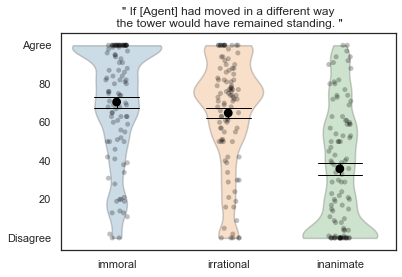

In [7]:
d3_diff = d3.loc[d3.CF_question == 'Q3']
g = sns.violinplot(x='condition', y='agreement',  data=d3_diff, cut=0, bw=.18, order=['animate_moral', 'animate_rational', 'inanimate'], inner=None)
[x.set_alpha(.25) for x in g.collections]

sns.stripplot(x='condition', y='agreement',  data=d3_diff, alpha=.25,  color='k', order=['animate_moral', 'animate_rational', 'inanimate'])
sns.pointplot(x='condition', y='agreement',  data=d3_diff,  color='k', order=['animate_moral', 'animate_rational', 'inanimate'], join=False, capsize=.4, errwidth=1, ci=68, scale=1)

g.axes.set_xlabel('')
g.axes.set_ylabel('')
g.axes.set_yticklabels(['0', 'Disagree', '20', '40', '60', '80', 'Agree']);
g.axes.set_xticklabels(['immoral', 'irrational', 'inanimate'])
g.axes.title.set_text('\" If [Agent] had moved in a different way\n the tower would have remained standing. \"')
#a1.text(-1.15, 110, "C.",fontsize=18, fontweight='bold' );
g.figure.savefig('Figures/Exp3_CF_3.png', dpi=300)


In [8]:
d3_cfd = d3.loc[(d3.CF_question == 'Q0') | (d3.CF_question == 'Q1')]
d3_cfd.loc[d3_cfd.CF_question == "Q0", 'CF_question'] = "Agent"
d3_cfd.loc[d3_cfd.CF_question == "Q1", 'CF_question'] = "Patient"



In [15]:
d3_cfd.loc[(d3_cfd.condition == 'animate_rational') & (d3_cfd.CF_question == 'Agent'), 'agreement'].mean()

34.54081632653061

In [104]:
dat2.to_csv('../../Data/Experiment_2/e3_dat.csv', sep=',')

In [133]:
#dat2.loc[(dat2.animacy == 'animate') & (dat2.norm_violation == 'rational')].agent.mean()
dat2.loc[dat2.animacy == 'inanimate'].patient.std()


25.233267396537347

In [141]:
import pingouin as pg

dat2['ap_diff'] = dat2.patient - dat2.agent
cond = 'animate_moral'
print(f'patient : {dat2.loc[dat2.condition ==  cond].patient.mean()}, SD: {dat2.loc[dat2.condition ==  cond].patient.std()}')
pg.ttest(dat2.loc[dat2.condition == cond].patient, dat2.loc[dat2.condition == cond].agent, paired=True)

patient : 55.96938775510204, SD: 32.22263214421975


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.833281,97,two-sided,0.069828,"[-21.34, 0.85]",0.332613,0.558,0.903193


In [149]:
d3_cfd.loc[(d3_cfd.condition == 'animate_rational') & (d3_cfd.CF_question == 'Agent')].agreement.mean()

34.03061224489796

In [142]:
dat3

,id,prolificID,jspsychID,time_elapse,stim1,stim2,Q0,Q1,Q2,Q3,...,num_movesQ0,QQ0,num_movesQ1,QQ1,num_movesQ2,QQ2,num_movesQ3,QQ3,animacy,norm_violation
0,1,5ed904c2bc8c1143e3e1a3fd,ob4ym5km2uwybyd,64443.0,../static/stimuli/part1_anim.mp4,../static/stimuli/test_stim2.mp4,[0],[80],[64],[55],...,1,0,1,80,1,64,1,55,animate,rational
1,2,602ee3b62e34a2b511c23dc4,sr7hrmauyf7hegz,95776.0,../static/stimuli/part1_anim.mp4,../static/stimuli/test_stim2.mp4,[10],[22],[100],[60],...,1,10,1,22,1,100,1,60,animate,rational
2,3,5f567b43fe297c0afa22468a,vqmh1ckpkzscy3k,114227.0,../static/stimuli/part1_anim.mp4,../static/stimuli/test_stim2.mp4,[0],[100],"[57, 62]","[64, 62]",...,1,0,1,100,2,62,2,62,animate,rational
3,4,60bf58fdf814d2c749a35458,jqxvpwtx3rpa6j8,124109.0,../static/stimuli/part1_anim.mp4,../static/stimuli/test_stim2.mp4,[17],[85],[96],[73],...,1,17,1,85,1,96,1,73,animate,rational
4,5,596de39c9fd5ee0001b704c3,pq4abxe2ffz3h2d,82136.0,../static/stimuli/part1_anim.mp4,../static/stimuli/test_stim2.mp4,[50],[100],[89],[79],...,1,50,1,100,1,89,1,79,animate,rational
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,336,5a99f17035237b0001128ff2,sfkamltpky21xn9,139219.0,../static/stimuli/part1_phys.mp4,../static/stimuli/test_stim1.mp4,[77],[58],[28],[43],...,1,77,1,58,1,28,1,43,inanimate,None
290,337,5e6f4a7338d4525042c296ef,y9rfjft0uthhl7h,44278.0,../static/stimuli/part1_phys.mp4,../static/stimuli/test_stim1.mp4,[20],[33],[37],[34],...,1,20,1,33,1,37,1,34,inanimate,None
291,339,5bf0d82b5823f30001538ff5,wrpsvz4zm2der2q,115994.0,../static/stimuli/part1_phys.mp4,../static/stimuli/test_stim1.mp4,[0],[0],"[56, 83]",[74],...,1,0,1,0,2,83,1,74,inanimate,None
292,340,5fb430c4ca50ba09c09927fe,k7ff9rgj4mhdp5f,41064.0,../static/stimuli/part1_phys.mp4,../static/stimuli/test_stim1.mp4,[35],[0],[25],[59],...,1,35,1,0,1,25,1,59,inanimate,None


In [145]:
d3_cfd.to_csv('../../Data/Experiment_3/CFD_items.csv', sep=',')

In [158]:
d3_exp['animacy'] = False
d3_exp.loc[d3_exp.condition != 'inanimate', 'animacy'] = True
d3_exp.to_csv('../../Data/Experiment_3/agnt_suprs.csv', sep=',')

<ipython-input-158-675a9de62862>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_exp['animacy'] = False


In [156]:
d3_exp.loc[(d3_exp.condition == 'inanimate')].agreement.std()

29.4256561605633

In [159]:
d3_diff['animacy'] = False
d3_diff.loc[d3_diff.condition != 'inanimate', 'animacy'] = True
d3_diff.to_csv('../../Data/Experiment_3/agnt_diff.csv', sep=',')

<ipython-input-159-8decaf4989ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_diff['animacy'] = False


In [11]:
cond = 'animate_moral'
print(f'mean : {d3_diff.loc[(d3_diff.condition == cond)].agreement.mean()}')
print(f'SD : {d3_diff.loc[(d3_diff.condition == cond)].agreement.std()}')



NameError: name 'd3_diff' is not defined

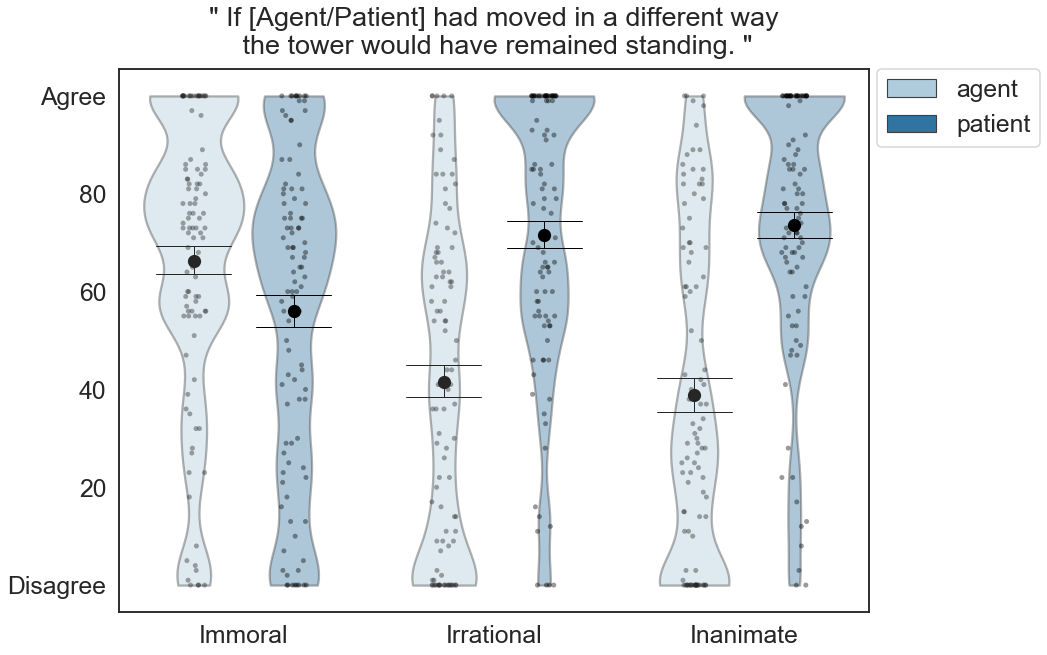

In [9]:
sns.set_context('talk', font_scale=1.5)

#d2 = dat2.melt(id_vars=['prolificID', 'condition'], value_vars=['agent', 'patient'], var_name='Ball', value_name='Causal Rating')
d2 = d3.loc[d3.CF_question == 'Q3']

fig, ax = plt.subplots(figsize=(15,10))

g = sns.violinplot(x='condition', y='Causal Rating', hue='Ball', data=d2, inner=None, cut=0, bw=.18, palette=sns.color_palette("Paired"), order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'])
[x.set_alpha(.4) for x in g.axes.collections]

g = sns.stripplot(x='condition', y='Causal Rating', hue='Ball', data=d2, alpha=.4, dodge=.4, color='k', order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'])

g = sns.pointplot(x='condition', y='Causal Rating', hue='Ball', data=d2, join=False, order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'], capsize=.3, errwidth=1, ci=68, scale=1, dodge=.4, color = 'k')#, palette=['k','r'])#, 'k','k','k','r'])
g.legend_.remove()
ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,ncol=1)
g.legend = False

#g.axes.collections[14].set_fc(['#FF00FF', '#32CD32', 'k'])
#g.axes.collections[14].set_ec(['#FF00FF', '#32CD32', 'k'])
#g.axes.collections[0].set_facecolor('#FF00FF')
#g.axes.collections[0].set_alpha(.25)
#g.axes.collections[2].set_facecolor('g')
#g.axes.collections[2].set_alpha(.25)

#ax.text(-.09, 108, "n="+str(len(d2.loc[(d2.condition=='animate_moral') ])))
#ax.text(1, 108, "n="+str(len(d2.loc[(d2.condition=='animate_rational')  ])))
#ax.text(2, 108, "n="+str(len(d2.loc[(d2.condition=='inanimate') ])))
#ax.set_ylabel(' \"The [agent / patient] caused \n the tower to collapse.\"', rotation=90, labelpad=-30)
ax.set_title('\" If [Agent/Patient] had moved in a different way\n the tower would have remained standing. \"', rotation=0, pad=15)

ax.set_xlabel('')
ax.set_ylabel('')

ax.set_yticklabels(['0', 'Disagree', '20', '40', '60', '80', 'Agree']);
ax.set_xticklabels(['Immoral', 'Irrational', 'Inanimate'])
fig.subplots_adjust(left=.105, right=.8)
fig.savefig('Figures/Exp2_cfdepend.png', dpi=300)

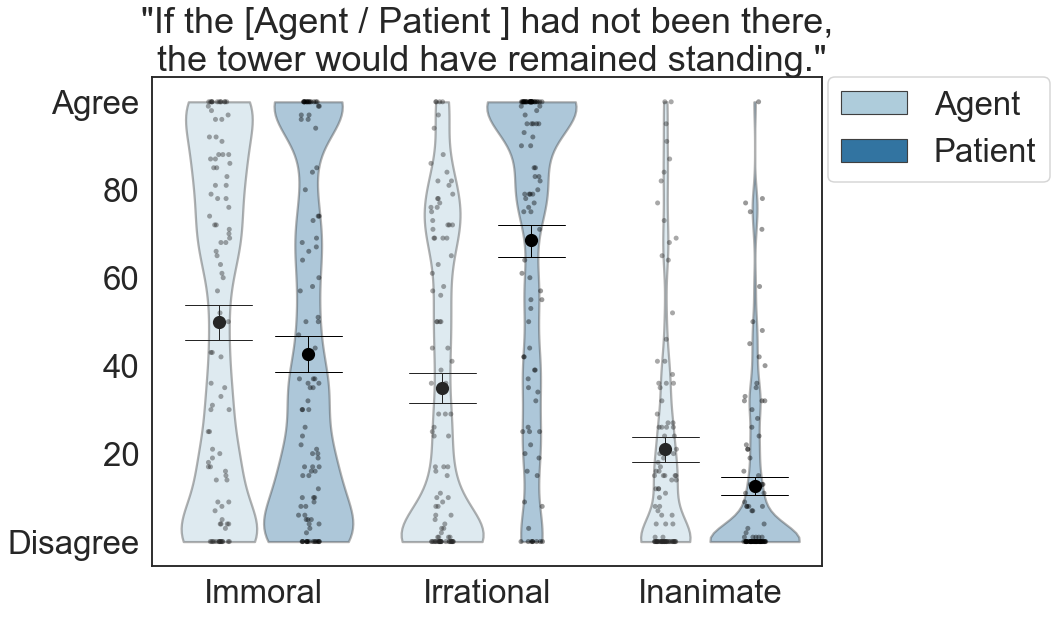

In [18]:
fig, a3 = plt.subplots(figsize=(15,9))
d3_cfd = d3.loc[(d3.CF_question == 'Q0') | (d3.CF_question == 'Q1')]
d3_cfd.loc[d3_cfd.CF_question == "Q0", 'CF_question'] = "Agent"
d3_cfd.loc[d3_cfd.CF_question == "Q1", 'CF_question'] = "Patient"

sns.violinplot(x='condition', y='agreement',hue='CF_question', data=d3_cfd, cut=0, bw=.18, palette=sns.color_palette("Paired"), order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['Agent', 'Patient'], inner=None, ax=a3)
[x.set_alpha(.4) for x in a3.collections]
sns.stripplot(x='condition', y='agreement', hue='CF_question', data=d3_cfd, alpha=.4, dodge=.4, color='k', order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['Agent', 'Patient'], ax=a3)
sns.pointplot(x='condition', y='agreement', hue='CF_question', data=d3_cfd, dodge=.4, color='k', order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['Agent', 'Patient'], ax=a3, join=False, capsize=.3, errwidth=1, ci=68, scale=1)
a3.legend_.remove()
a3.legend(a3.get_legend_handles_labels()[0][:2], a3.get_legend_handles_labels()[1][:2], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
a3.title.set_text('\"If the [Agent / Patient ] had not been there,\n the tower would have remained standing.\"');
a3.set_yticklabels(['0', 'Disagree', '20', '40', '60', '80', 'Agree']);
a3.set_xticklabels(['Immoral', 'Irrational', 'Inanimate'])

a3.set_xlabel('');
a3.set_ylabel("");
fig.subplots_adjust(left=.15, right=.77)
fig.savefig('Figures/Exp2_cfdepend1.png', dpi=300)

#a3.text(-.8, 110, "A.",fontsize=18, fontweight='bold' );

ValueError: Could not interpret input 'Ball'

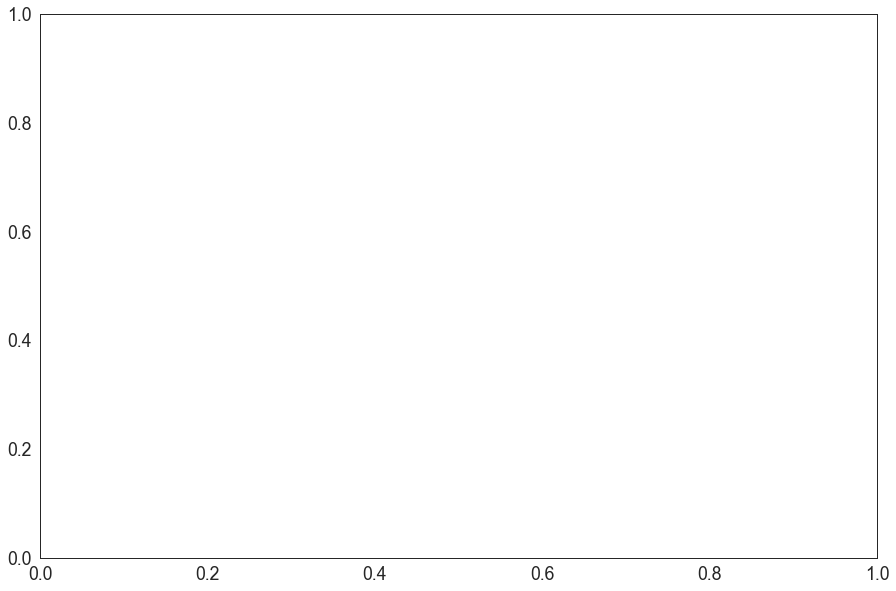

In [19]:
sns.set_context('paper', font_scale=2)

d2 = dat2.melt(id_vars=['prolificID', 'condition'], value_vars=['agent', 'patient'], var_name='Ball', value_name='Causal Rating')
fig, ax = plt.subplots(figsize=(15,10))

g = sns.violinplot(x='condition', y='agreement', hue='Ball', data=d3_cfd, inner=None, cut=0, bw=.18, palette=sns.color_palette("Paired"), order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'])
[x.set_alpha(.4) for x in g.axes.collections]

g = sns.stripplot(x='condition', y='agreement', hue='Ball', data=d3_cfd, alpha=.4, dodge=.4, color='k', order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'])

g = sns.pointplot(x='condition', y='agreement', hue='Ball', data=d3_cfd, join=False, order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'], capsize=.3, errwidth=1, ci=68, scale=1, dodge=.4, color = 'k')#, palette=['k','r'])#, 'k','k','k','r'])
g.legend_.remove()
ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,ncol=1)
g.legend = False

g.axes.collections[14].set_fc(['#FF00FF', '#32CD32', 'k'])
g.axes.collections[14].set_ec(['#FF00FF', '#32CD32', 'k'])
#g.axes.collections[0].set_facecolor('#FF00FF')
#g.axes.collections[0].set_alpha(.25)
#g.axes.collections[2].set_facecolor('g')
#g.axes.collections[2].set_alpha(.25)

#ax.text(-.09, 108, "n="+str(len(d2.loc[(d2.condition=='animate_moral') ])))
#ax.text(1, 108, "n="+str(len(d2.loc[(d2.condition=='animate_rational')  ])))
#ax.text(2, 108, "n="+str(len(d2.loc[(d2.condition=='inanimate') ])))
#ax.set_ylabel(' \"The [agent / patient] caused \n the tower to collapse.\"', rotation=90, labelpad=-30)
ax.set_title(' \"The [agent / patient] caused the tower to collapse.\"', rotation=0, pad=15)

ax.set_xlabel('')
ax.set_ylabel('')

ax.set_yticklabels(['0', 'Disagree', '20', '40', '60', '80', 'Agree']);
ax.set_xticklabels(['animate immoral', 'animate irrational', 'inanimate'])
fig.subplots_adjust(left=.1, right=.87)
#fig.savefig('Figures/Exp2_causebb.pdf', dpi=300)

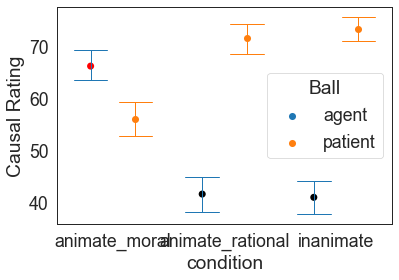

In [61]:

g = sns.pointplot(x='condition', y='Causal Rating', hue='Ball', data=d2, join=False, order=['animate_moral', 'animate_rational', 'inanimate'], hue_order=['agent', 'patient'], capsize=.3, errwidth=1, ci=68, scale=1, dodge=.4, )
g.axes.collections[0].set_fc(['r', 'k', 'k'])
g.axes.collections[0].set_ec(['r', 'k', 'k'])
#g.axes.set_facecolor(['r', 'k','k','k','k','k'])

In [62]:
x = g.axes.collections[0]

In [64]:
y = g.axes.collections[0].get_capstyle()